In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
import shap
%matplotlib inline

seed(888)

# 1. Load data from "2. Preprocessing"

In [2]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("2_brain_test.pkl")
brain_train = pd.read_pickle("2_brain_train.pkl")
main_test = pd.read_pickle("2_main_test.pkl")
main_train = pd.read_pickle("2_main_train.pkl")
main_test_all = pd.read_pickle("2_main_test_all.pkl")
brain_test_all = pd.read_pickle("2_brain_test_all.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)
main_train = pd.DataFrame(main_train)
main_test_all = pd.DataFrame(main_test_all)
brain_test_all = pd.DataFrame(brain_test_all)

Chose dataset with or without excluded people

In [3]:
main_test = main_test_all
brain_test = brain_test_all

# 2. Delte rows with nan in any brain segmentation

In [4]:

nan_all_test = brain_test[brain_test.iloc[:,1:2544:2].isnull().any(axis=1)].index
nan_all_train = brain_train[brain_train.iloc[:,1:2544:2].isnull().any(axis=1)].index
main_test = main_test.drop(nan_all_test)
#main_train = main_train.drop(nan_all_train)
brain_test = brain_test.drop(nan_all_test)
brain_train = brain_train.drop(nan_all_train)

print("Number of people with missing brain values in train set:", len(nan_all_train))
print("Number of people with missing brain values in test set:", len(nan_all_test))

Number of people with missing brain values in train set: 42
Number of people with missing brain values in test set: 20


# 3. BrainAge with different segmentations

## 3.1. A2009s Segmentation (Thickness and Area)

In [5]:
X_train = brain_train.iloc[:,1657:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1657:2544:2]
Y_test = brain_test.iloc[:,-1]

### 3.1.1. Cross validation

In [6]:
# set of alphas to try (=penalization)
alpha_parameters = np.power(10,np.linspace(start=-3, stop=5, num=100))

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

coeff = np.asarray(abs(model.coef_))
top_10_coefficients = np.argsort(coeff)[-10:]
print(X_train_std.iloc[:,top_10_coefficients].columns)
print(coeff[top_10_coefficients])


The MAE for cross-validation (Ridge): 4.178356335982309
Index(['volume_of_sparietooccipital_right_hemisphere_f27763_2_0',
       'volume_of_gfrontsup_left_hemisphere_f27492_2_0',
       'area_of_latfispost_right_hemisphere_f27591_2_0',
       'volume_of_gscingulant_right_hemisphere_f27704_2_0',
       'volume_of_scentral_right_hemisphere_f27743_2_0',
       'area_of_gfrontsup_left_hemisphere_f27344_2_0',
       'volume_of_scentral_left_hemisphere_f27521_2_0',
       'volume_of_scalcarine_right_hemisphere_f27742_2_0',
       'area_of_scalcarine_right_hemisphere_f27594_2_0',
       'volume_of_latfispost_right_hemisphere_f27739_2_0'],
      dtype='object')
[1.38012529 1.38904935 1.45666916 1.51370264 1.56313099 1.57054797
 2.04761872 2.10064593 2.1589445  2.22170588]


### 3.1.2. Brain Age model predicting test data

The MAE for testing set using Ridge: 4.253509132682956


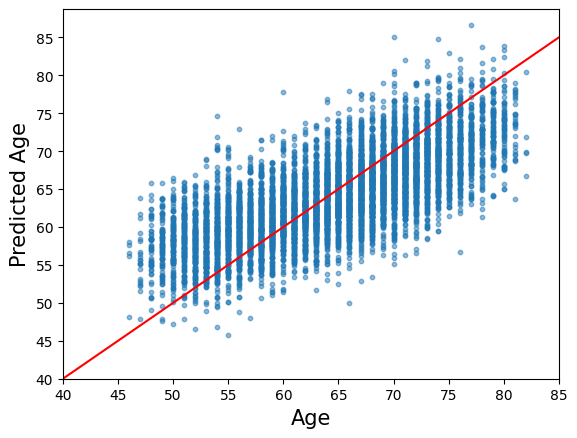

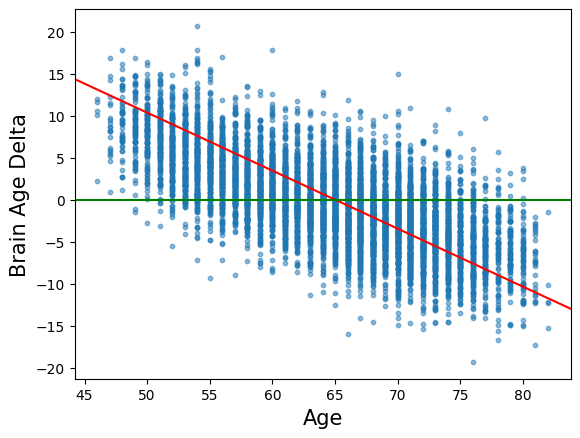

In [7]:
# BrainAge model for testing data
# model trained on training tested on test
# model initialization - options to use Lasso, Ridge or SVM

#model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000)
model_Ridge = RidgeCV(alphas = alpha_parameters)
#model_SVR = SVR(kernel = 'rbf')

# train model on training data
#model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
#model_SVR.fit(X_train_std,Y_train)

# get predicted values for test set
#y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
#y_pred_SVR = model_SVR.predict(X_test_std)

# calculate brain age gap
#brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
#brain_age_delta_SVR = y_pred_SVR-Y_test

# get mean absolute error (MAE)
#print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
#print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))

#plot figure with x: actual age Y: predicted age, and a line with slope 1 for reference
plt.figure()
plt.scatter(Y_test, y_pred_Ridge, alpha=0.5, s=10)
plt.axline((60,60), slope=1, color='r')
plt.xticks(range(40,90,5))
plt.yticks(range(40,90,5))
plt.ylabel('Predicted Age', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.show()

plt.figure()
plt.scatter(Y_test,brain_age_delta_Ridge, alpha=0.5, s=10)
plt.axline((65,0), slope=-0.69, color="r")
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()


### 3.1.3. BrainAge Correction

Coefficient and Intercept: 0.5394718243976903 29.658905248225935


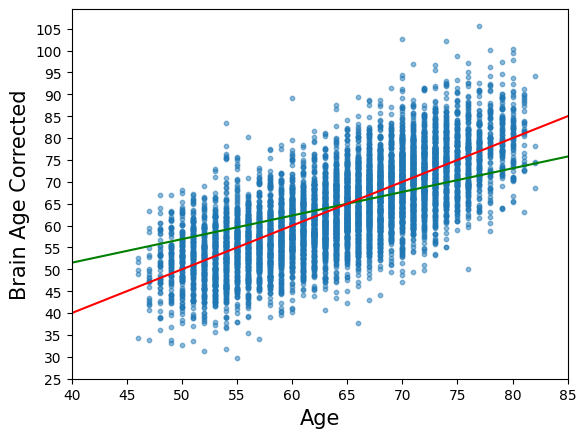

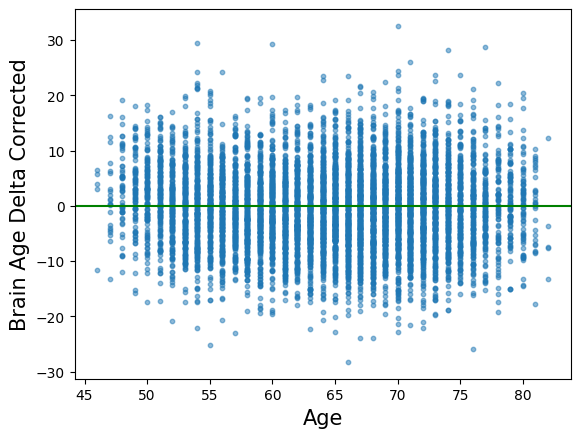

In [8]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_1 = vfunc(y_pred_Ridge)
corr_brainage_delta_1 = corr_brainage_1-Y_test


plt.figure()
plt.scatter(Y_test, corr_brainage_1, alpha=0.5, s=10)
plt.axline((65,65), slope=coef, color="g")
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta_1, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

## 3.2. ASEG Segmentation

In [9]:
# select Freesurfer ASEG for training data
whole_brain = brain_train.iloc[:,27:70:2]
left_hemi = brain_train.iloc[:,103:134:2]
right_hemi = brain_train.iloc[:,165:196:2]
age = brain_train["Age"]
ASEG_train = pd.DataFrame(pd.concat([whole_brain,left_hemi, right_hemi,age],axis = 1))

# select Freesurfer ASEG for testing data
whole_brain = brain_test.iloc[:,27:70:2]
left_hemi = brain_test.iloc[:,103:134:2]
right_hemi = brain_test.iloc[:,165:196:2]
age = brain_test["Age"]
ASEG_test = pd.DataFrame(pd.concat([whole_brain,left_hemi, right_hemi,age],axis = 1))

X_train = ASEG_train.iloc[:,:-1]
Y_train = ASEG_train.iloc[:,-1]
X_test = ASEG_test.iloc[:,:-1]
Y_test = ASEG_test.iloc[:,-1]

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

# model initialization - options to use Lasso, Ridge or SVM
#model = LassoCV(alphas = alpha_parameters, max_iter=100000)
model = RidgeCV(alphas = alpha_parameters)
#model = SVR(kernel = 'rbf')

# train model on training data
model.fit(X_train_std,Y_train)

# get predicted values for test set
y_pred = model.predict(X_test_std)

# calculate brain age gap
brain_age_delta = y_pred-Y_test

# get mean absolute error (MAE)
print("The MAE for testing set:", mean_absolute_error(Y_test,y_pred))

coeff = np.asarray(abs(model.coef_))
top_10_coefficients = np.argsort(coeff)[-10:]
print(X_train_std.iloc[:,top_10_coefficients].columns)
print(coeff[top_10_coefficients])

The MAE for cross-validation (Ridge): 4.101965497239333
The MAE for testing set: 4.3604871472644815
Index(['volume_of_supratentorial_whole_brain_f26519_2_0',
       'volume_of_ventriclechoroid_whole_brain_f26522_2_0',
       'volume_of_brainsegnotventsurf_whole_brain_f26516_2_0',
       'volume_of_totalgray_whole_brain_f26518_2_0',
       'volume_of_lateralventricle_right_hemisphere_f26585_2_0',
       'volume_of_subcortgray_whole_brain_f26517_2_0',
       'volume_of_supratentorialnotvent_whole_brain_f26520_2_0',
       'volume_of_lateralventricle_left_hemisphere_f26554_2_0',
       'volume_of_brainsegnotvent_whole_brain_f26515_2_0',
       'volume_of_brainseg_whole_brain_f26514_2_0'],
      dtype='object')
[  8.07057504  16.31946125  20.47625319  24.33259849  30.74076376
  31.23345954  33.82111448  35.5476273  394.71740071 409.87408795]


### 3.2.1. Correction and Plots

Coefficient and Intercept: 0.5451303770808593 29.192774061686578


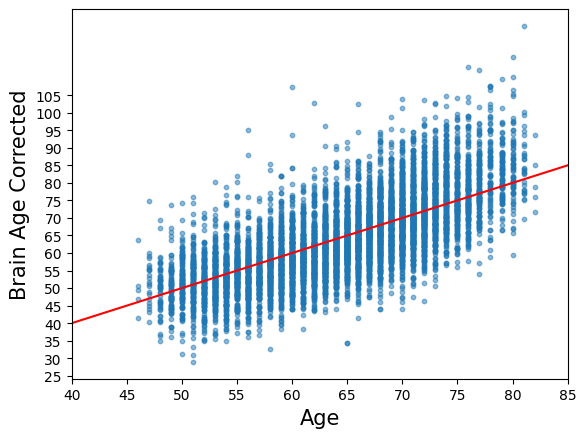

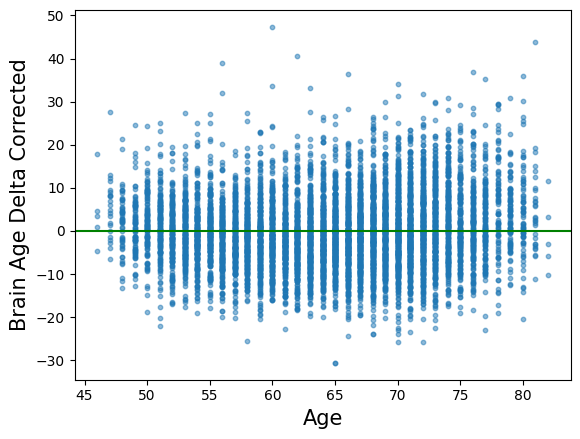

In [10]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_2 = vfunc(y_pred)
corr_brainage_delta_2 = corr_brainage_2-Y_test


plt.figure()
plt.scatter(Y_test, corr_brainage_2, alpha=0.5, s=10)
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta_2, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

## 3.3. Desikan pial

The MAE for cross-validation (Ridge): 5.700505063026127
The MAE for testing set: 5.956385118925303


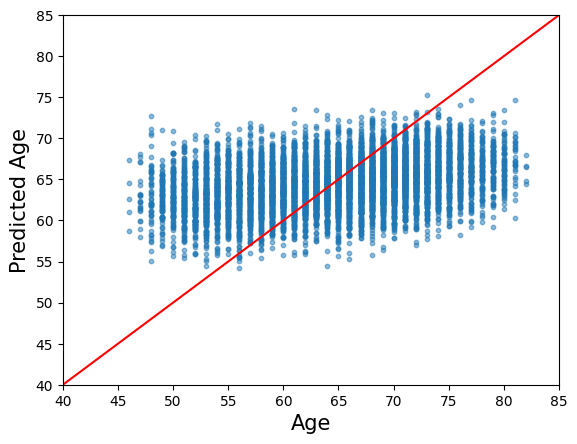

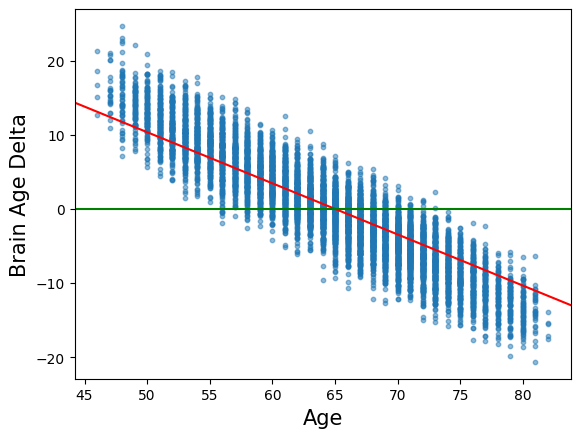

In [11]:
X_train = brain_train.iloc[:,845:976:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,845:976:2]
Y_test = brain_test.iloc[:,-1]

# standardize x-data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

# model initialization - options to use Lasso, Ridge or SVM
#model = LassoCV(alphas = alpha_parameters, max_iter=100000)
#model = RidgeCV(alphas = alpha_parameters)
model = SVR(kernel = 'rbf')

# train model on training data
model.fit(X_train_std,Y_train)

# get predicted values for test set
y_pred = model.predict(X_test_std)

# calculate brain age gap
brain_age_delta = y_pred-Y_test

# get mean absolute error (MAE)
print("The MAE for testing set:", mean_absolute_error(Y_test,y_pred))

plt.figure()
plt.scatter(Y_test, y_pred, alpha=0.5, s=10)
plt.axline((60,60), slope=1, color='r')
plt.xticks(range(40,90,5))
plt.yticks(range(40,90,5))
plt.ylabel('Predicted Age', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.show()

plt.figure()
plt.scatter(Y_test,brain_age_delta, alpha=0.5, s=10)
plt.axline((65,0), slope=-0.69, color="r")
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

### 3.3.1. BrainAge Correction

Coefficient and Intercept: 0.17271525612644412 53.21521911445886


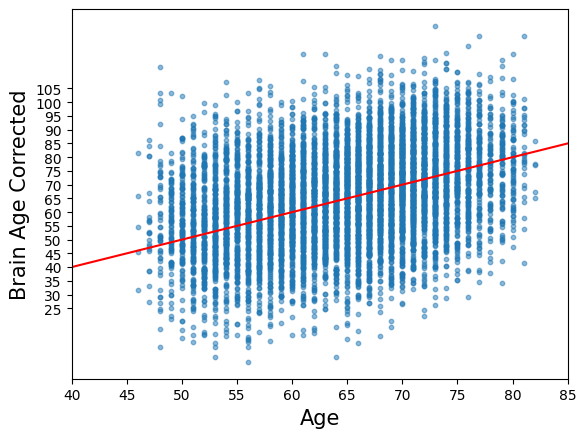

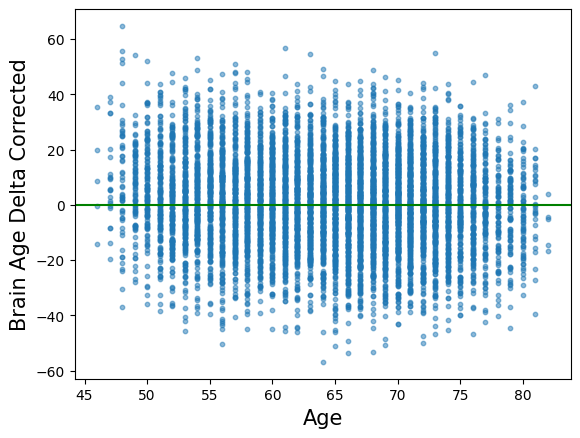

In [12]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_3 = vfunc(y_pred)
corr_brainage_delta_3 = corr_brainage_3-Y_test


plt.figure()
plt.scatter(Y_test, corr_brainage_3, alpha=0.5, s=10)
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta_3, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

## 3.4. All Brain Variables

The MAE for cross-validation (Ridge): 3.0647491156733095
Index(['volume_of_vlp_left_hemisphere_f26686_2_0',
       'mean_intensity_of_3rdventricle_whole_brain_f26501_2_0',
       'mean_intensity_of_accumbensarea_left_hemisphere_f26548_2_0',
       'mean_intensity_of_caudate_left_hemisphere_f26543_2_0',
       'volume_of_midbrain_whole_brain_f26719_2_0',
       'greywhite_contrast_in_inferiorparietal_right_hemisphere_f27031_2_0',
       'greywhite_contrast_in_precuneus_left_hemisphere_f27013_2_0',
       'volume_of_wholebrainstem_whole_brain_f26720_2_0',
       'volume_of_ventraldc_right_hemisphere_f26596_2_0',
       'volume_of_pons_whole_brain_f26717_2_0'],
      dtype='object')
[0.6416308  0.64657282 0.64898987 0.64951277 0.72717357 0.76849623
 0.79190702 0.87692071 0.8917615  1.18980925]


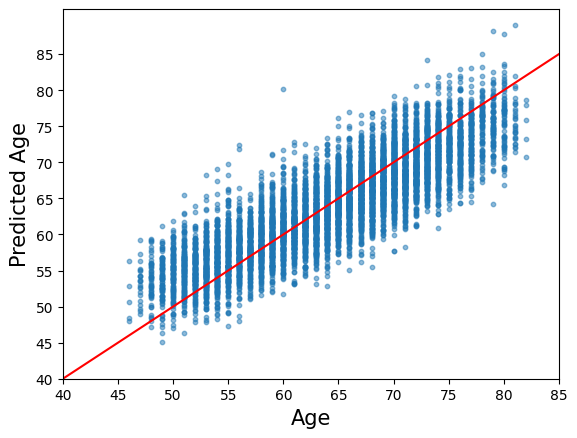

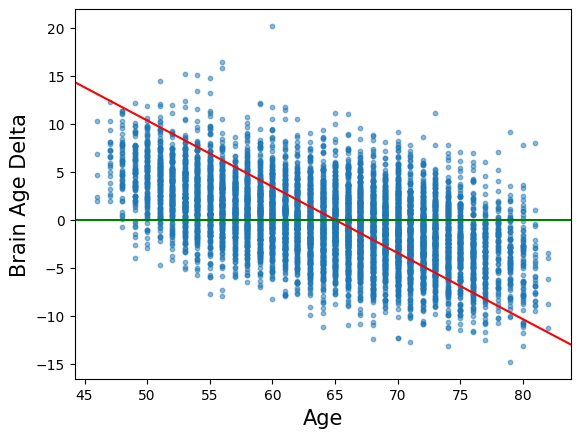

In [13]:
X_train = brain_train.iloc[:,1:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1:2544:2]
Y_test = brain_test.iloc[:,-1]

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)
#print(X_train_std)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

#model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000, tol=1e-2)
model_Ridge = RidgeCV(alphas = alpha_parameters)
#model_SVR = SVR(kernel = 'rbf')

# train model on training data
#model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
#model_SVR.fit(X_train_std,Y_train)


coeff = np.asarray(abs(model_Ridge.coef_))
top_10_coefficients = np.argsort(coeff)[-10:]
print(X_train_std.iloc[:,top_10_coefficients].columns)
print(coeff[top_10_coefficients])

# get predicted values for test set
#y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
#y_pred_SVR = model_SVR.predict(X_test_std)

# calculate brain age gap
#brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
#brain_age_delta_SVR = y_pred_SVR-Y_test

# # get mean absolute error (MAE)
# print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
# print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
# print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))

# print("The Spearman r for Ridge vs Lasso:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_Lasso))
# print("The Spearman r for Ridge vs SVR:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_SVR))
# print("The Spearman r for SVR vs Lasso:", stats.spearmanr(brain_age_delta_SVR, brain_age_delta_Lasso))



plt.figure()
plt.scatter(Y_test, y_pred_Ridge, alpha=0.5, s=10)
plt.axline((60,60), slope=1, color='r')
plt.xticks(range(40,90,5))
plt.yticks(range(40,90,5))
plt.ylabel('Predicted Age', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.show()

plt.figure()
plt.scatter(Y_test,brain_age_delta_Ridge, alpha=0.5, s=10)
plt.axline((65,0), slope=-0.69, color="r")
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

### 3.4.1. Correction and plots

Coefficient and Intercept: 0.7473056979712567 16.184077044061304
The MAE for testing set corrected: 3.5843126252016138


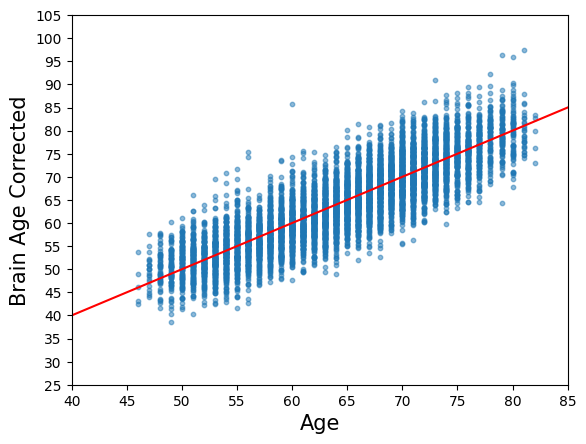

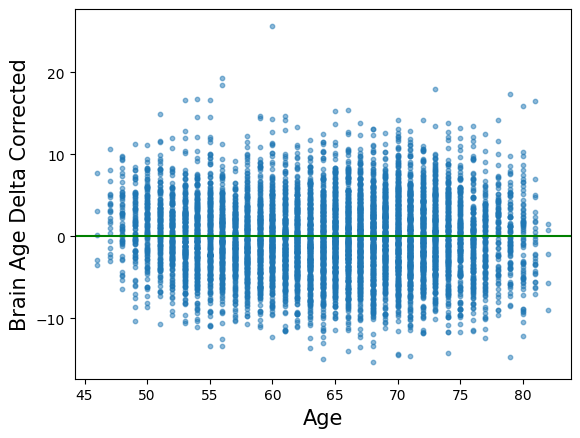

In [14]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_4 = vfunc(y_pred_Ridge)
corr_brainage_delta_4 = corr_brainage_4-Y_test

print("The MAE for testing set corrected:", mean_absolute_error(Y_test,corr_brainage_4))

plt.figure()
plt.scatter(Y_test, corr_brainage_4, alpha=0.5, s=10)
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta_4, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

# 4. Add BrainAge Deltas to main_test

In [15]:
main_test["BA A2009 Delta Corr"] = corr_brainage_delta_1
main_test["BA ASEG Delta Corr"] = corr_brainage_delta_2
main_test["BA Desikan Delta Corr"] = corr_brainage_delta_3
main_test["BA Corr"] = corr_brainage_4
main_test["BA Delta Corr"] = corr_brainage_delta_4

# 5. Pickle data for next script

In [16]:
# pickle results
main_test.to_pickle("3_main_test.pkl")
main_train.to_pickle("3_main_train.pkl")
brain_test.to_pickle("3_brain_test.pkl")
brain_train.to_pickle("3_brain_train.pkl")